Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only). Vocal channel (01 = speech, 02 = song). Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised). Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"). Repetition (01 = 1st repetition, 02 = 2nd repetition). Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [39]:
import librosa as lr
import librosa.disp
import librosa 
import os
import pandas as pd
import numpy as np
lay

import matplotlib.pyplot as plt

import pickle

import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import warnings

warnings.simplefilter("ignore")


ModuleNotFoundError: No module named 'librosa.disp'

In [2]:
# CREATE DIRECTORY OF AUDIO FILES 
audio = "/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/"
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [3]:
# EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
emotion = []
gender = []
actor = []
file_path = []
for i in actor_folders:
    filename = os.listdir(audio + i) #iterate over Actor folders
    for f in filename: # go through files in Actor folder
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append(audio + i + '/' + f)

In [4]:
# PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)
audio_df.head()

,gender,emotion,actor,path
0,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpee...
1,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpee...
2,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpee...
3,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpee...
4,male,calm,1,/Users/diebl/lab/FinalProject__RecognitionSpee...


In [5]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', -1)
#Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
audio_df.sample(10)

,gender,emotion,actor,path
701,female,fear,12,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_12/03-01-06-02-01-02-12.wav
604,male,calm,11,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_11/03-01-02-01-01-01-11.wav
1418,female,fear,24,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_24/03-01-06-01-02-01-24.wav
1060,female,fear,18,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_18/03-01-06-02-01-01-18.wav
174,male,surprise,3,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_03/03-01-08-01-02-01-03.wav
86,female,sad,2,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_02/03-01-04-02-02-01-02.wav
978,male,happy,17,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_17/03-01-03-02-02-01-17.wav
34,male,angry,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-05-02-02-01-01.wav
416,male,surprise,7,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_07/03-01-08-02-01-01-07.wav
958,female,surprise,16,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_16/03-01-08-02-02-01-16.wav


<AxesSubplot:>

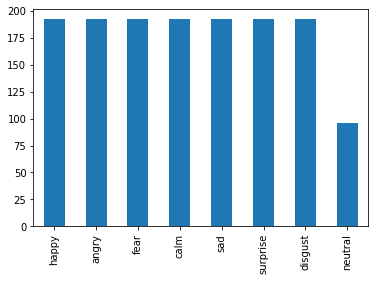

In [6]:
# LOOK AT DISTRIBUTION OF CLASSES
audio_df.emotion.value_counts().plot(kind='bar')

In [6]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (transform both the y-axis (frequency) to log scale, 
    #and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    df.loc[counter] = [log_spectrogram]
    counter=counter+1   


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1439
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mel_spectrogram  1440 non-null   object
dtypes: object(1)
memory usage: 22.5+ KB


In [8]:
# TURN ARRAY INTO LIST AND JOIN WITH AUDIO_DF TO GET CORRESPONDING EMOTION LABELS
df_final = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_final = df_final.fillna(0)

In [9]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Columns: 263 entries, gender to 258
dtypes: float64(259), int64(1), object(3)
memory usage: 2.9+ MB


In [10]:
df_final.head()

,gender,emotion,actor,path,0,1,2,3,4,5,...,249,250,251,252,253,254,255,256,257,258
0,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav,-75.335518,-75.445320,-75.554031,-75.203949,-75.230530,-75.319374,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male,neutral,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male,calm,1,/Users/diebl/lab/FinalProject__RecognitionSpeechEmotion/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,...,-80.147377,-80.147377,-80.121956,-79.998009,-80.119255,-80.147377,-80.130417,-80.014702,-80.147377,-80.147377


In [11]:
# DROP PATH COLUMN FOR MODELING
df_final.drop(columns='path',inplace=True)

In [27]:
df_final.to_csv('mel_24_8.csv')

## MODELING

In [13]:
# drop the target value
X = df_final.drop('emotion', axis=1)
y = df_final['emotion']


In [14]:
#encoding gender feature

X= pd.get_dummies(X)
X.head()

,actor,0,1,2,3,4,5,6,7,8,...,251,252,253,254,255,256,257,258,gender_female,gender_male
0,1,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
1,1,-75.335518,-75.445320,-75.554031,-75.203949,-75.230530,-75.319374,-75.653793,-75.720039,-75.720039,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
2,1,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.139587,-75.072227,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
3,1,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1
4,1,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,...,-80.121956,-79.998009,-80.119255,-80.147377,-80.130417,-80.014702,-80.147377,-80.147377,0,1


In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Columns: 262 entries, actor to gender_male
dtypes: float64(259), int64(1), uint8(2)
memory usage: 2.9 MB


In [16]:
X.describe()

,actor,0,1,2,3,4,5,6,7,8,...,251,252,253,254,255,256,257,258,gender_female,gender_male
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,12.500000,-65.868048,-65.698825,-65.640956,-65.568078,-65.506128,-65.419256,-65.347965,-65.302798,-65.183665,...,-51.995080,-52.063892,-49.689682,-49.746698,-49.799431,-46.947218,-46.939368,-46.965840,0.500000,0.500000
std,6.924591,10.371453,10.428921,10.461182,10.527195,10.585247,10.672489,10.759296,10.828546,10.889351,...,26.850166,26.844289,28.214197,28.220034,28.235346,29.606611,29.620484,29.671197,0.500174,0.500174
min,1.000000,-93.463219,-93.463219,-93.463219,-93.463219,-93.463219,-93.463219,-93.463219,-93.463219,-93.463219,...,-91.494263,-92.346512,-92.707253,-90.854004,-91.525177,-91.248116,-91.135559,-93.463219,0.000000,0.000000
25%,6.750000,-73.483334,-73.275942,-73.277733,-73.272263,-73.355021,-73.393129,-73.326874,-73.302509,-73.337681,...,-70.129290,-70.161228,-69.615944,-69.660076,-69.851355,-69.312422,-69.370422,-69.402653,0.000000,0.000000
50%,12.500000,-66.796566,-66.612537,-66.496750,-66.500889,-66.480679,-66.398308,-66.233547,-66.253014,-66.041084,...,-62.608332,-62.740196,-61.675755,-61.680185,-61.773211,-60.280519,-60.280519,-60.187666,0.500000,0.500000
75%,18.250000,-59.451980,-58.952798,-58.818537,-58.793196,-58.693053,-58.254225,-58.307713,-58.256474,-57.992487,...,-48.034685,-47.641583,-41.252725,-41.633215,-42.640772,0.000000,0.000000,0.000000,1.000000,1.000000
max,24.000000,-29.005959,-28.733444,-29.339039,-30.352173,-31.362858,-30.006647,-24.170176,-19.226366,-20.815470,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000


In [15]:
X1 = X.copy()
X2 = X.copy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
model = MLPClassifier(hidden_layer_sizes=(200,), learning_rate='adaptive', max_iter=400)

In [18]:
model.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(200,), learning_rate='adaptive', max_iter=400)

In [19]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy of the Recognizer is: {:.1f}%".format(accuracy*100))

Accuracy of the Recognizer is: 28.1%


Analysis of the accuracy : 

the model doesn't detect happy, suprised and fearful at all.

angry ->recall
calm -> precision 

In [20]:
emotions = ['neutral','calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
print(classification_report(y_test, y_pred, labels=['neutral','calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']))

              precision    recall  f1-score   support

     neutral       0.11      0.10      0.10        20
        calm       0.45      0.41      0.43        44
       happy       0.31      0.15      0.20        34
         sad       0.24      0.36      0.29        39
       angry       0.50      0.45      0.48        42
     fearful       0.00      0.00      0.00         0
     disgust       0.33      0.22      0.26        32
   surprised       0.00      0.00      0.00         0

   micro avg       0.34      0.31      0.32       211
   macro avg       0.24      0.21      0.22       211
weighted avg       0.35      0.31      0.32       211



In [21]:
""""checking the results that we get : we can notice that the model is not good at predicting all the emotions. 
 It predicts "disgust" or "angry more than the other emotions."""


print(f"y_test[10:30]={y_test[10:30]}")
print(f"y_pred[10:30]={y_pred[10:30]}")

y_test[10:30]=589     disgust 
115     surprise
1223    sad     
940     fear    
141     sad     
1305    disgust 
695     angry   
756     fear    
306     calm    
350     disgust 
1192    surprise
1023    neutral 
1140    neutral 
620     sad     
819     fear    
746     sad     
654     surprise
415     surprise
51      disgust 
270     angry   
Name: emotion, dtype: object
y_pred[10:30]=['disgust' 'happy' 'disgust' 'angry' 'sad' 'sad' 'angry' 'fear' 'sad'
 'calm' 'fear' 'fear' 'sad' 'neutral' 'fear' 'neutral' 'fear' 'angry'
 'fear' 'calm']


## Improving the model

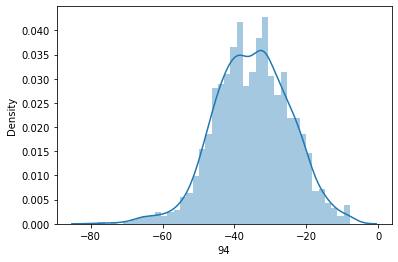

In [50]:
sns.distplot(df_final[94], bins=40)
plt.show()




**with standardization**

In [23]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=42)

In [24]:
#standardization

transformer = StandardScaler()
transformer.fit(X1_train)

# saving in a pickle
with open('std_transformer1.pickle', 'wb') as file:
    pickle.dump(transformer, file)
    
# loading from a pickle  
with open('std_transformer1.pickle', 'rb') as file:
    loaded_standardized = pickle.load(file)

X1_train = loaded_standardized.transform(X1_train)
X1_test = loaded_standardized.transform(X1_test)

In [25]:
model = MLPClassifier(hidden_layer_sizes=(200,), learning_rate='adaptive', max_iter=400)

In [27]:
model.fit(X1_train, y1_train)

MLPClassifier(hidden_layer_sizes=(200,), learning_rate='adaptive', max_iter=400)

In [28]:
y_pred = model.predict(X1_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy of the Recognizer is: {:.1f}%".format(accuracy*100))

Accuracy of the Recognizer is: 48.3%


In [29]:
print(classification_report(y_test, y_pred, labels=['neutral','calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']))

              precision    recall  f1-score   support

     neutral       0.35      0.45      0.39        20
        calm       0.72      0.66      0.69        44
       happy       0.33      0.50      0.40        34
         sad       0.39      0.38      0.39        39
       angry       0.61      0.60      0.60        42
     fearful       0.00      0.00      0.00         0
     disgust       0.48      0.41      0.44        32
   surprised       0.00      0.00      0.00         0

   micro avg       0.48      0.51      0.50       211
   macro avg       0.36      0.37      0.36       211
weighted avg       0.50      0.51      0.50       211



**with normalization**

In [30]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [31]:
#normalization

transformer = Normalizer()
transformer.fit(X2_train)

# saving in a pickle
with open('std_transformer2.pickle', 'wb') as file:
    pickle.dump(transformer, file)
    
# loading from a pickle  
with open('std_transformer2.pickle', 'rb') as file:
    loaded_normalizer = pickle.load(file)

X_train_ = loaded_normalizer.transform(X2_train)
X_test_ = loaded_normalizer.transform(X2_test)

In [32]:
model = MLPClassifier(hidden_layer_sizes=(200,), learning_rate='adaptive', max_iter=400)

In [33]:
model.fit(X1_train, y1_train)

MLPClassifier(hidden_layer_sizes=(200,), learning_rate='adaptive', max_iter=400)

In [34]:
y_pred = model.predict(X1_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy of the Recognizer is: {:.1f}%".format(accuracy*100))

Accuracy of the Recognizer is: 44.8%


In [35]:
print(classification_report(y_test, y_pred, labels=['neutral','calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']))

              precision    recall  f1-score   support

     neutral       0.29      0.45      0.35        20
        calm       0.63      0.61      0.62        44
       happy       0.33      0.53      0.41        34
         sad       0.34      0.26      0.29        39
       angry       0.62      0.60      0.61        42
     fearful       0.00      0.00      0.00         0
     disgust       0.43      0.31      0.36        32
   surprised       0.00      0.00      0.00         0

   micro avg       0.45      0.47      0.46       211
   macro avg       0.33      0.34      0.33       211
weighted avg       0.47      0.47      0.46       211



## With other features in addition to mel spectogramm : signal, spectrum and pitches

In [ ]:
time = np.arange(0,len(y))/sr

S = np.abs(librosa.stft(y))

pitches, magnitudes = lr.piptrack(y=y, sr=sr)

spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000


In [43]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING 
df1 = pd.DataFrame(columns=['mel_specto' ])

counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (transform both the y-axis (frequency) to log scale, 
    
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
  
        
    df.loc[counter] = [spectrogram]
    counter=counter+1   
 """"   
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (transform both the y-axis (frequency) to log scale, 
    
    time = np.arange(0,len(y))/sr
     
        
    df.loc[counter] = [time]
    counter=counter+1
    
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (transform both the y-axis (frequency) to log scale, 
    
    S = np.abs(librosa.stft(y))
     
        
    df.loc[counter] = [spectrum]
    counter=counter+1
    
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (transform both the y-axis (frequency) to log scale, 
    
    pitches, magnitudes = lr.piptrack(y=y, sr=sr)
     
        
    df.loc[counter] = [pitches]
    counter=counter+1
    """

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 16)

In [44]:
df2 = pd.DataFrame(columns=['time' ])

counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
     
    
    time = np.arange(0,len(y))/sr
     
        
    df.loc[counter] = [time]
    counter=counter+1
    

NameError: name 'sr' is not defined

In [46]:
df3 = pd.DataFrame(columns=['spectrum' ])
counter=0
for index,path in enumerate(audio_df.path):
    
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
 
    S = np.abs(librosa.stft(y))
     
        
    df.loc[counter] = [spectrum]
    counter=counter+1

ParameterError: Audio data must be of type numpy.ndarray

In [48]:
df4 = pd.DataFrame(columns=['pitches' ])
counter=0

for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (transform both the y-axis (frequency) to log scale, 
    
    pitches, magnitudes = lr.piptrack(y=y, sr=sr)
     
        
    df.loc[counter] = [pitches]
    counter=counter+1

NameError: name 'sr' is not defined

sélectionner d'autres features